In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn import svm, metrics
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, r2_score
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
import pickle as pkl
from sklearn.linear_model import LassoCV

np.random.seed(42)

In [2]:
train_data = pd.read_csv("handout/train_features.csv", delimiter=",")
train_labels = pd.read_csv("handout/train_labels.csv", delimiter=",")
test_data = pd.read_csv("handout/test_features.csv", delimiter=",")

train_data = train_data.sort_values(['pid','Time'])
train_labels = train_labels.sort_values(['pid'])
test_data = test_data.sort_values(['pid','Time'])

## Data Manipulation and Feature Engineering

Manipulations were performed following what was suggested [here](https://www.kdnuggets.com/2018/12/feature-engineering-explained.html). Multiple operations were attempted, resulting in this sequence as the most succesful one:

- add a new feature for each of the existing ones that has a 1 if the value is present, 0 if missing (NaN)
- subsitute NaNs with the mean of the column (python's SimpleImputer allows to replace missing values with also median, most frequent, etc., but I don't think it would make such a difference - see also [this link](https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/) for reference)
- normalize each column
- change each value of time to a 1-12 range, in order to smoothly pivot and use each value of time as a different feature (note: this way we loose the information regarding in which moment of the day we took the measurements - it should be investigated whether or not this actually has an impact)

When it comes to divide the given dataset into train and validation subsets, I took care of balancing them, having the same number of 0s and 1s in the labels

What else was tried?
I also tried to add a feature which is sum of the number of non-NaN fields for each row. The idea was to use this value as a per-sample weight and feed it to ```sample_weight``` arg of the ```fit``` function. This actually proved to decrease the area under the ROC curve, while in some cases it made it better when cuts based on this feature were applied (but still without using it as per-sample weight). This is however not implemented in the final version.

In [3]:
# new feature that keeps track of wheter or not a certain feature was present
for col in train_data.columns[3:]:
    train_data[f"{col}_notna"] = train_data[col].notna().astype(int)

for col in test_data.columns[3:]:
    test_data[f"{col}_notna"] = test_data[col].notna().astype(int)

In [4]:
# substitute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
imputer.fit(train_data)
train_data_implaced = imputer.transform(train_data)
train_data_implaced = pd.DataFrame(train_data_implaced, columns=train_data.columns)

imputer = SimpleImputer(strategy='mean')
imputer.fit(test_data)
test_data_implaced = imputer.transform(test_data)
test_data_implaced = pd.DataFrame(test_data_implaced, columns=test_data.columns)

In [5]:
# normalize
for col in train_data_implaced.columns[2:]:
    train_data_implaced[col] = (train_data_implaced[col] - train_data_implaced[col].min()) / (train_data_implaced[col].max() - train_data_implaced[col].min())

for col in test_data_implaced.columns[2:]:
    test_data_implaced[col] = (test_data_implaced[col] - test_data_implaced[col].min()) / (test_data_implaced[col].max() - test_data_implaced[col].min())

In [6]:
# same values for time
train_data_implaced["Time"] = list(range(1, 13)) * len(list(set(train_data_implaced["pid"])))
test_data_implaced["Time"] = list(range(1, 13)) * len(list(set(test_data_implaced["pid"])))

In [7]:
# pivot
train_data_pivoted = train_data_implaced.pivot(index="pid", columns="Time", values=train_data_implaced.columns[2:])
test_data_pivoted = test_data_implaced.pivot(index="pid", columns="Time", values=test_data_implaced.columns[2:])

In [8]:
train_labels = train_labels.set_index("pid")
train_labels = train_labels.sort_index()

In [9]:
def balance_dataset(train_data, train_labels, label):
    train_data_0 = train_data[train_labels[label] == 0]
    train_data_1 = train_data[train_labels[label] == 1]

    n = min(train_data_0.shape[0], train_data_1.shape[0])
    train_data_ok = pd.concat([train_data_0.sample(n), train_data_1.sample(n)])
    train_data_ok = shuffle(train_data_ok)

    train_labels_ok = train_labels.loc[train_data_ok.index, label]

    return train_data_ok, train_labels_ok

In [10]:
labels = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
# only to test
#labels = ["LABEL_BaseExcess"]

## Subtask 1

LABEL_BaseExcess
ROC AUC: 0.9101640171004333
LABEL_Fibrinogen
ROC AUC: 0.7442117010223324
LABEL_AST
ROC AUC: 0.6926871049678067
LABEL_Alkalinephos
ROC AUC: 0.7105568963976043
LABEL_Bilirubin_total
ROC AUC: 0.7150716632187872
LABEL_Lactate
ROC AUC: 0.7958393857646815
LABEL_TroponinI
ROC AUC: 0.8590495154283168
LABEL_SaO2
ROC AUC: 0.8327630485925719
LABEL_Bilirubin_direct
ROC AUC: 0.7316953316953316
LABEL_EtCO2
ROC AUC: 0.9143380304115915


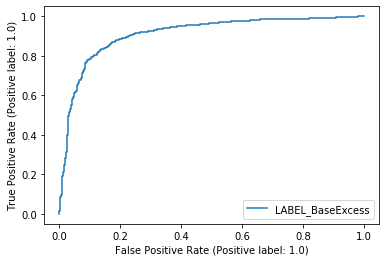

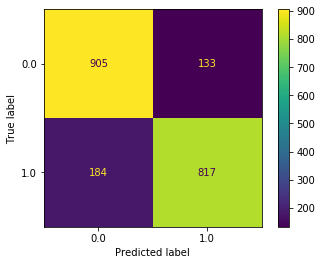

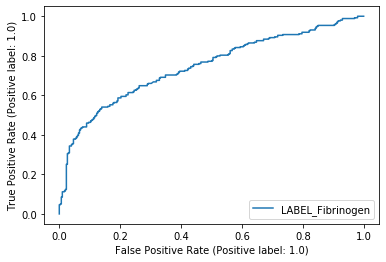

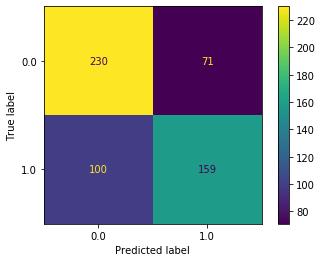

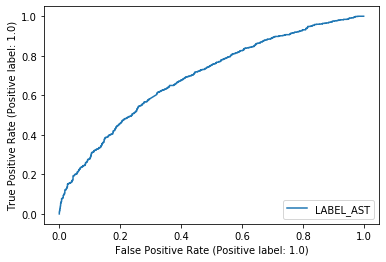

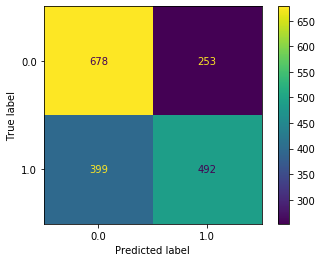

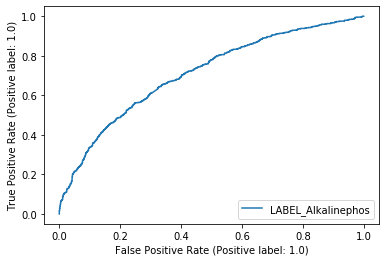

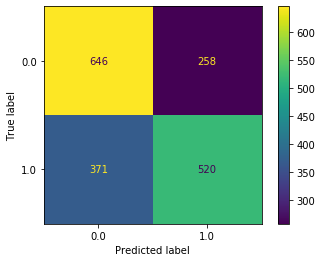

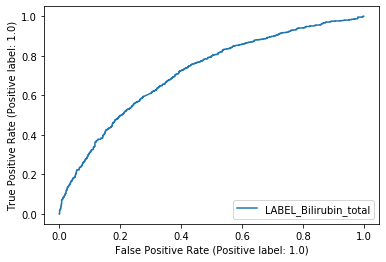

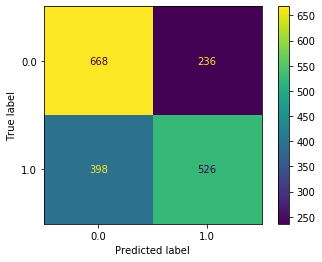

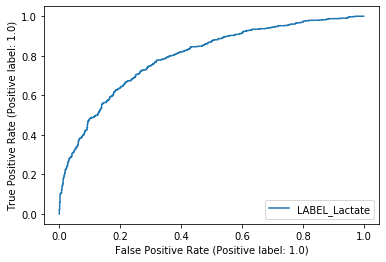

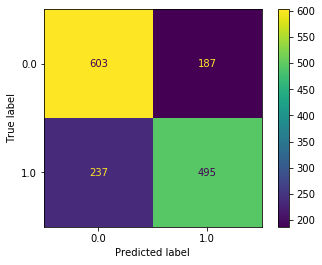

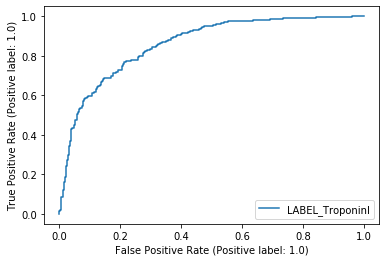

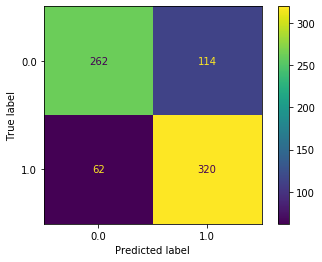

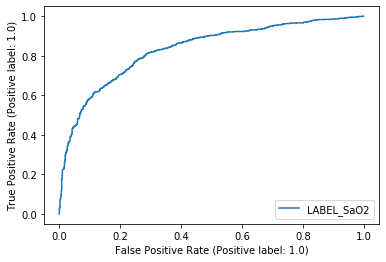

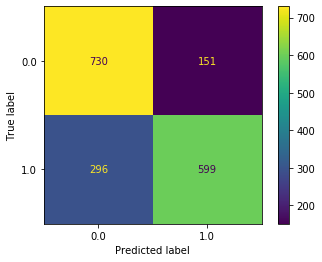

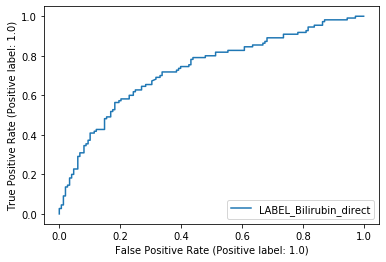

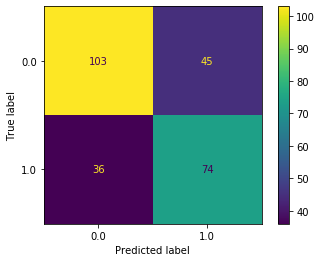

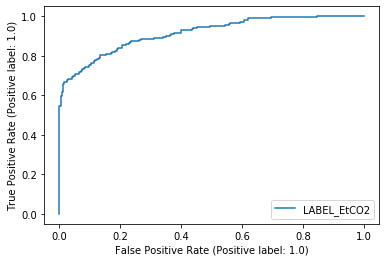

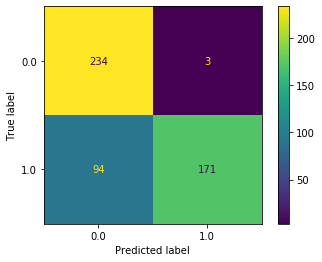

In [11]:
for label in labels:
    train_data_balanced, train_labels_balanced = balance_dataset(train_data_pivoted, train_labels, label)
    X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)

    try:
        with open("models/{}.pkl".format(label), "rb") as f:
            clf = pkl.load(f)
    except:
        clf = svm.SVC(probability=True)
        clf.fit(X_train, y_train)
        with open("models/{}.pkl".format(label), "wb") as f:
            pkl.dump(clf, f)
    
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Evaluation
    print(label)
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
    plot_roc_curve(clf, X_test, y_test, label=label)
    plot_confusion_matrix(clf, X_test, y_test);

## Subtask 2

In [12]:
label = "LABEL_Sepsis"

LABEL_Sepsis
ROC AUC: 0.7101926977687627


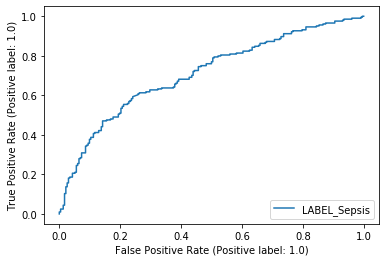

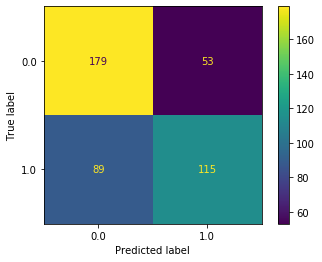

In [13]:
train_data_balanced, train_labels_balanced = balance_dataset(train_data_pivoted, train_labels, label)
X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, train_labels_balanced, test_size=0.2, random_state=42)

try:
    with open("models/{}.pkl".format(label), "rb") as f:
        clf = pkl.load(f)
except:
    clf = svm.SVC(probability=True)
    clf.fit(X_train, y_train)
    with open("models/{}.pkl".format(label), "wb") as f:
        pkl.dump(clf, f)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print(label)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba)}")
plot_roc_curve(clf, X_test, y_test, label=label)
plot_confusion_matrix(clf, X_test, y_test);

## Subtask 3

In [16]:
labels = ["LABEL_RRate", "LABEL_ABPm", "LABEL_SpO2", "LABEL_Heartrate"]
# to test
#labels = ["LABEL_RRate"]

In [17]:
for label in labels:
    train_labels_single = train_labels[label]
    X_train, X_test, y_train, y_test = train_test_split(train_data_pivoted, train_labels_single, test_size=0.2, random_state=42)

    try:
        with open("models/{}.pkl".format(label), "rb") as f:
            regressor = pkl.load(f)
    except:
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
        regressor = LassoCV(alphas=np.linspace(0.00001, 1, 1000), max_iter=10000, cv=cv)
        regressor.fit(X_train, y_train)
        with open("models/{}.pkl".format(label), "wb") as f:
            pkl.dump(regressor, f)
    
    y_pred = regressor.predict(X_test)

    # Evaluation
    print(label)
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2}")

LABEL_RRate
R2: 0.43964747275007754
LABEL_ABPm
R2: 0.6271991021843828
LABEL_SpO2
R2: 0.39806638497076374
LABEL_Heartrate
R2: 0.6443348847795811


Apply all models to test data and dump the results

In [18]:
labels_t1 = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST', 'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct', 'LABEL_EtCO2']
labels_t2 = ["LABEL_Sepsis"]
labels_t3 = ["LABEL_RRate", "LABEL_ABPm", "LABEL_SpO2", "LABEL_Heartrate"]

output = pd.DataFrame()
output["pid"] = test_data_pivoted.index.astype(int)
for label in labels_t1 + labels_t2:
    print(label)
    with open("models/{}.pkl".format(label), "rb") as f:
        clf = pkl.load(f)
    y_pred = clf.predict_proba(test_data_pivoted)[:, 1]
    output[label] = y_pred

for label in labels_t3:
    print(label)
    with open("models/{}.pkl".format(label), "rb") as f:
        regressor = pkl.load(f)
    y_pred = regressor.predict(test_data_pivoted)
    output[label] = y_pred

LABEL_BaseExcess
LABEL_Fibrinogen
LABEL_AST
LABEL_Alkalinephos
LABEL_Bilirubin_total
LABEL_Lactate
LABEL_TroponinI
LABEL_SaO2
LABEL_Bilirubin_direct
LABEL_EtCO2
LABEL_Sepsis
LABEL_RRate
LABEL_ABPm
LABEL_SpO2
LABEL_Heartrate


In [19]:
sample_data = pd.read_csv("handout/sample.zip", delimiter=",")

output_t = output.set_index("pid")
output_t = output_t.reindex(sample_data["pid"].to_numpy())
output_t = output_t.reset_index()
output_t = output_t.rename(columns={"index": "pid"})
output_t.to_csv('task2_masgalli.zip', index=False, float_format='%.3f', compression='zip')